# Importando Bibliotecas Necessárias

In [77]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.metrics import confusion_matrix,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import eli5
from eli5.sklearn import PermutationImportance

import shap

# Introdução

A ABC é uma empresa de varejo que vende diferentes itens para seus clientes. Para aumentar as suas vendas, ela decidiu conceder crédito para estes clientes com base em um modelo automático de risco. Mais especificamente, dadas diversas informações sobre um cliente X, obtidas no momento da requisição de crédito, ela quer inferir o risco associado a X, ou seja, **a probabilidade de que X não vai pagar a dívida**
que ele contraiu nos meses subsequentes se tornando assim um mau pagador.

O objetivo desse notebook é propor um modelo que faça essa tarefa de classificar os clientes entre bons e maus pagadores.



# Dados

A empresa forneceu dados de clientes solicitantes de crédito no periodo dos meses de agosto e setembro de 2015. Para cada cliente estão disponíveis 15 informações divididas em 4 categorias:


*   demo = Informações Demográficas
*   job1 = Informações sobre emprego
*   income = Informações sobre renda
*   debt = Informações sobre débitos anteriores

Além disso a empresa também informou se esse cliente nos meses seguintes foi um bom pagador ou não. A coluna 'target' indica se aquele cliente é:

* 0 = bom pagador
* 1 = mau pagador





In [2]:
path_csv = 'sample15k_synth.csv'
data = pd.read_csv(path_csv)

features = data.keys()
data.head()

,date,demo1,demo2,demo3,demo4,demo5,demo6,job1,job2,job3,job4,income1,income2,debt1,debt2,debt3,target
0,2015-08-25,18,-1,1,4,12,1,0,0,19,2,0,1034.5000,-1,0,NaN,0
1,2015-08-12,24,1,1,4,60,1,1,0,0,2,0,1344.8500,0,0,0.8218,0
2,2015-08-08,41,1,1,3,98,1,1,0,0,4,0,2275.9000,2,0,0.9558,1
3,2015-08-14,30,0,1,5,108,1,0,0,30,2,0,1344.8500,5,0,0.9304,0
4,2015-08-28,18,-1,1,4,120,1,0,0,0,4,0,1008.6375,-1,0,NaN,0


Para testar o desempenho do modelo proposto separaremos os dados em dois conjuntos. Os dados coletados em agosto de 2015 serão usados para realizar os treinos e os dados coletados em Setembro de 2015 serão utilizados apenas para teste apenas para teste.

In [4]:
train,test = data.query("date < '2015-09-01'") , data.query("date >= '2015-09-01'")

print('{} Samples for train \n{} Samples for test'
          .format(len(train),len(test)))

10000 Samples for train 
5000 Samples for test


A primeira vista podemos observar a ausencia de valores na coluna **debt3**. Vamos verificar se há outras colunas que contém campos não preenchidos.

In [5]:
#verifica quantas das celulas de uma coluna estão vazias
data.isnull().sum()

date         0
demo1        0
demo2        0
demo3        0
demo4        0
demo5        0
demo6        0
job1         0
job2         0
job3         0
job4         0
income1      0
income2      0
debt1        0
debt2        0
debt3      454
target       0
dtype: int64

Apenas a coluna **debt3** contém campos não preenchidos, para tratar isso substituiremos essas linhas que não contém valores pela mediana dos valores que já estão preenchidos. 

In [6]:
# mediana dos valores contidos na coluna 'debt3'
median_debt3 = train["debt3"].median()

#Preenchimento de todas as linhas que estão com o campo vazio
train["debt3"].fillna(median_debt3, inplace=True)

#Usaremos a mesma mediana acima para preencher os dados de teste
test["debt3"].fillna(median_debt3, inplace=True)

train.head()

,date,demo1,demo2,demo3,demo4,demo5,demo6,job1,job2,job3,job4,income1,income2,debt1,debt2,debt3,target
0,2015-08-25,18,-1,1,4,12,1,0,0,19,2,0,1034.5000,-1,0,0.8510,0
1,2015-08-12,24,1,1,4,60,1,1,0,0,2,0,1344.8500,0,0,0.8218,0
2,2015-08-08,41,1,1,3,98,1,1,0,0,4,0,2275.9000,2,0,0.9558,1
3,2015-08-14,30,0,1,5,108,1,0,0,30,2,0,1344.8500,5,0,0.9304,0
4,2015-08-28,18,-1,1,4,120,1,0,0,0,4,0,1008.6375,-1,0,0.8510,0


Observando uma descrição geral das features e os histogramas de cada coluna podemos ter uma ideia geral de como estão dispostos os dados de cada coluna. As features abaixo podem ser divididas em variáveis Numéricas, Categoricas e Lógicas(Categoricas Binárias). No código abaixo separamos as features entre essas categorias: 

In [ ]:
cat_var = ['demo2','demo3','demo4', 'demo6','job4','debt1'] #Variaveis Categóricas
num_var = ['demo1', 'demo5','job3', 'income2','debt3'] #Variáveis Numéricas
logi_var = ['job1','job2', 'income1','debt2'] # Variáveis Lógicas

train.describe()

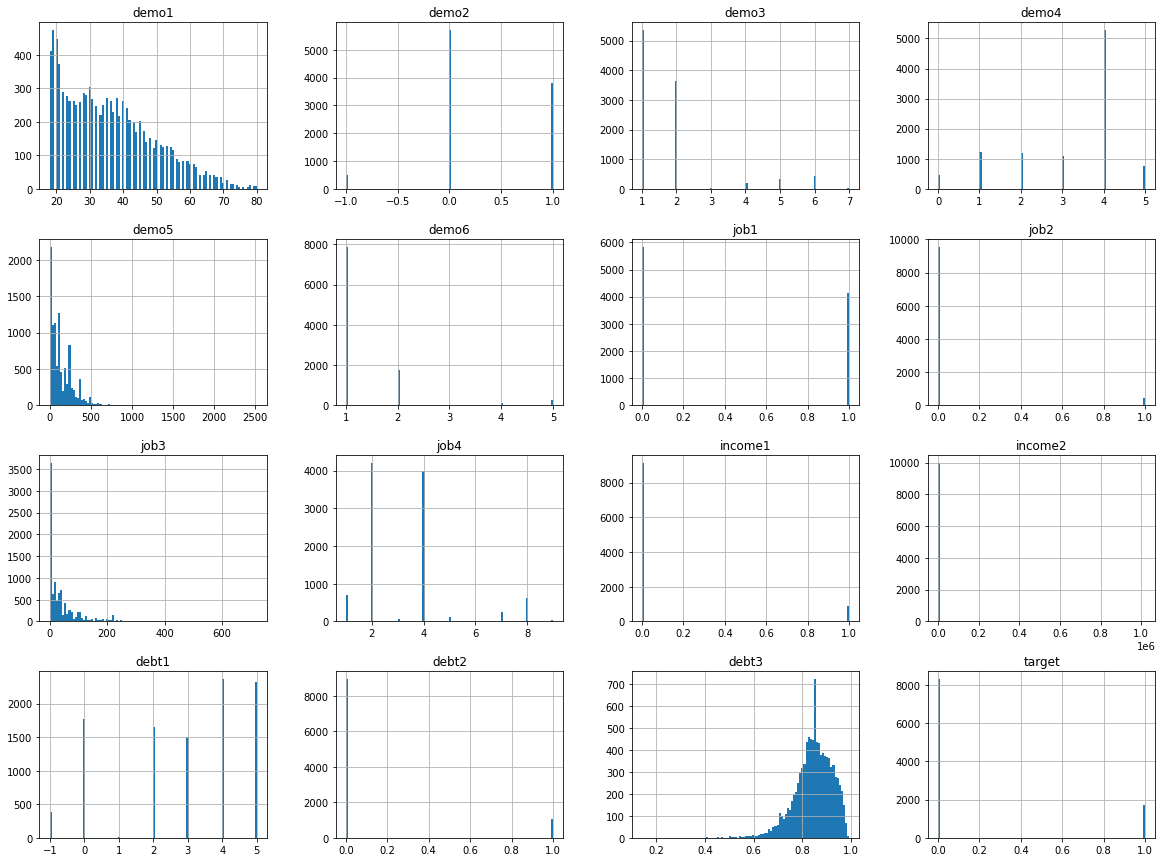

In [7]:
train.hist(bins=100, figsize=(20,15))
plt.show()

Olhando as características das features e os histogramas acima podemos destacar coisas como:

* As colunas 'demo1' e 'demo2' parecem se tratar respectivamente das seguintes informações: idade e genero.

* A coluna 'income2' possui a gigantesca maioria dos seus dados concentrados entre 0 e 10⁴ e alguns outliers fora desse range.

* O grande desbalanceamento entre clientes bons pagadores e clientes mau pagadores, como pode ser visto no histograma 'target'. Isso pode ser um problema para o treinamento dos modelos.


In [8]:
train_pos,train_neg = train.query("target == 1 ") , train.query("target == 0")
print("{} Mau Pagadores e {} Bons Pagadores".format(len(train_pos),len(train_neg)))


1705 Mau Pagadores e 8295 Bons Pagadores


# Avaliação

Para validar os modelos testados nesse notebook, faremos validação cruzada com 5 folds. Por fim testaremos os modelos junto aos dados de teste separados no começo do notebook.

Dado que existe um grande desbalanceamento entre as classes em nosso problema a acuracia não se encaixa tão bem como métrica de avaliação, pois se prevermos todos os clientes como bons pagadores já atingiremos uma alta acuracia uma vez que a maioria dos clientes são bons pagadores. Para avaliar os modelos aqui treinados utilizaremos métricas que avaliem o quão bem são avaliadas as classes em separado, utilizaremos:

* **Revocação**

> 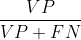


> Pois queremos diminuir o número de falsos negativos, isso é clientes que são maus pagadores mas são classificados como bons pagadores. Esse é um grande problema pois gera prejuizos para a empresa.

* **Especificidade**

> 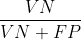

> Precisamos também de uma boa especificidade, uma vez que também queremos manter o número de Falsos positivos baixo. Um modelo que predissesse todos os clientes como mal pagadores teria uma revocação de 100%, entretanto se a empresa dependesse desse modelo nunca daria crédito a nenhum cliente.

* **AUC - Area Under Curve**

> Para balancear as duas métricas anteriores, usaremos a AUC como métrica principal para avaliar os nossos modelos. Está métrica calcula a Area sob a curva ROC, essa curva é um gráfico de diagnóstico para resumir o comportamento de um modelo, calculando as duas métricas acima sob diferentes limites.


Abaixo as funções para validação cruzada e avaliação com as métricas citadas acima.

In [20]:
def evaluateVal(model,X,y):
  scores = cross_validate(model, X, y,scoring={"roc_auc"}, cv=5)
  print("AUC = {}".format(
            scores['test_roc_auc'].mean()))
  
def evaluate(model,X,y):
  if(model == None):
    y_pred = np.ones(len(y))
  else:  
    y_pred = model.predict(X)
    
  vn, fp, fn, vp = confusion_matrix(y, y_pred).ravel()  
    
  print("Revocação = {}, Especificidade = {}, AUC = {}".format(
      vp/(vp+fn), vn/(vn+fp),roc_auc_score(y,y_pred)))

# Preparação dos dados

In [10]:
#Separando as colunas de caracteristicas do target 
X_train,y_train = train[features[1:16]],train.target
X_test,y_test = test[features[1:16]],test.target

# Modelos Utilizados

Para tentar construir um modelo que consiga distinguir entre bons e maus pagadores testarei dois dos mais famosos modelos de machine learning que utilizam do método de ensemble:


*   Random Forest
*   Gradient Boost



### Random Forest

Abaixo a função para realizar a GridSearch na Random Forest. 

In [11]:
# Grid Search for Random Forest
def gridSearch_RF(X,y,score):
  param_grid = [
          {'bootstrap': [True],
            'max_depth': [4,10,25, 50,100],
            'max_leaf_nodes':[16,32,64,None],
            'max_features': [2,5,7,10,12,15],
            'n_estimators': [1,10,100,200]},
          ]

  model= RandomForestClassifier(random_state=0)
  grid_search = GridSearchCV(model, param_grid, cv=5, scoring=score,return_train_score=True)
  grid_search.fit(X, y)
  print(grid_search.best_params_)

### Gradient Boosting

Abaixo a função para realizar a GridSearch no Gradient Boosting. 

In [12]:
# Grid Search

def gridSearch_XB(X,y,score):
  param_grid = {
      "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
      "max_depth":[3,5,7,9,13],
      "subsample":[0.3,0.5, 0.7, 1.0],
      "n_estimators":[10, 50, 100, 200]
  }

  model= GradientBoostingClassifier(random_state=0)
  grid_search = GridSearchCV(model, param_grid, cv=5, scoring=score,return_train_score=True)
  grid_search.fit(X, y)
  print(grid_search.best_params_)

# Primeiro Teste

Para verificar o quão bem se saem os modelos com os dados disponibilizados quase inalterados, vamos fazer um gridsearch nos modelos de Random Forest e Gradient Boost para encontrar os melhores parametros de treino e observar suas pontuações nas métricas. 

### Random Forest

In [33]:
# Grid Search para encontrar o melhor parametro para Random Forest com a metrica auc
gridSearch_RF(X_train,y_train,'roc_auc')

{'bootstrap': True, 'max_depth': 10, 'max_features': 2, 'max_leaf_nodes': None, 'n_estimators': 500}


In [25]:
#Modelo com os parametros escolhidos pelo grid search
RF = RandomForestClassifier(max_depth=10,max_features=2,n_estimators=500,random_state=0)

print("\nValidação Cruzada")
evaluateVal(RF,X_train,y_train)

#treino
RF.fit(X_train,y_train)

print("\nTeste no próprio conjunto de teste")
evaluate(RF,X_train,y_train)
print("\nModelo que só chuta 1")
evaluate(None,X_train,y_train)


Validação Cruzada
AUC = 0.6453108345309244

Teste no próprio conjunto de teste
Revocação = 0.008211143695014663, Especificidade = 1.0, AUC = 0.5041055718475074

Modelo que só chuta 1
Revocação = 1.0, Especificidade = 0.0, AUC = 0.5


Com os resultados acima, o primeiro modelo parece estar classificando muitos clientes como bons pagadores, assim apresentando muitos Falsos Negativos. Na validação cruzada consegue alcançar um bom AUC mas mesmo nos dados alcança um péssimo resultado.

### Gradient Boosting

In [27]:
# Grid Search para encontrar o melhor parametro para Gradient Boosting com a metrica auc
gridSearch_XB(X_train,y_train,'roc_auc')

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.5}


In [34]:
#Modelo com os parametros escolhidos pelo grid search
XG = GradientBoostingClassifier(learning_rate=0.01, max_depth=3,n_estimators=500,subsample=0.5,random_state=0)

print("\nValidação Cruzada")
evaluateVal(XG,X_train,y_train)

#treino
XG.fit(X_train,y_train)

print("\nTeste no próprio conjunto de teste")
evaluate(XG,X_train,y_train)
print("\nModelo que só chuta 1")
evaluate(None,X_train,y_train)


Validação Cruzada
AUC = 0.643935593466014

Teste no próprio conjunto de teste
Revocação = 0.002932551319648094, Especificidade = 1.0, AUC = 0.501466275659824

Modelo que só chuta 1
Revocação = 1.0, Especificidade = 0.0, AUC = 0.5


Comentario sobre os resultados acima

# Tentativas para melhorar desempenho

### Subsampling

Como dito anteriormente o grande desbalanceamento entre as classes pode causar um grande prejuízo no treino dos modelos. Para tentar diminuir esse prejuízo decidi verificar se temos uma melhora no desempenho dos modelos ao fazer um subsampling dos dados iniciais. O subsampling foi criado pegando todos os 1705 exemplos positivos + 1705 exemplos negativos aleatorios, assim nosso subsampling contém 3410 samples para o treino.

In [28]:
#Pegando um conjunto de 1705 samples dos exemplos negativos
train_neg_sub = train_neg.sample(n=len(train_pos))
print("{} Mau Pagadores e {} Bons Pagadores".format(len(train_pos),len(train_neg_sub)))

#Nosso subsampling
train_sub = pd.concat([train_pos,train_neg_sub])


X_train_sub,y_train_sub = train_sub[features[1:16]],train_sub.target

1705 Mau Pagadores e 1705 Bons Pagadores


In [29]:
# Grid Search para encontrar o melhor parametro para Random Forest com a metrica auc
gridSearch_RF(X_train_sub,y_train_sub,'roc_auc')

{'bootstrap': True, 'max_depth': 10, 'max_features': 2, 'max_leaf_nodes': None, 'n_estimators': 500}


In [35]:
RF_sub = RandomForestClassifier(max_depth=10,max_features=2,n_estimators=500,random_state=0)

print("\nValidação Cruzada")
evaluateVal(RF_sub,X_train_sub,y_train_sub)

#treino
RF_sub.fit(X_train_sub,y_train_sub)

print("\nTeste no próprio conjunto de teste")
evaluate(RF_sub,X_train_sub,y_train_sub)

print("\nModelo que só chuta 1")
evaluate(None,X_train_sub,y_train_sub)


Validação Cruzada
AUC = 0.6509042749890351

Teste no próprio conjunto de teste
Revocação = 0.9085043988269794, Especificidade = 0.787683284457478, AUC = 0.8480938416422288

Modelo que só chuta 1
Revocação = 1.0, Especificidade = 0.0, AUC = 0.5


In [30]:
gridSearch_XB(X_train_sub,y_train_sub,'roc_auc')

{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.3}


In [37]:
XG_sub = GradientBoostingClassifier(learning_rate=0.01,max_depth=7,n_estimators=200,subsample=0.3,random_state=0)

print("\nValidação Cruzada")
evaluateVal(XG_sub,X_train_sub,y_train_sub)

#treino
XG_sub.fit(X_train_sub,y_train_sub)

print("\nTeste no próprio conjunto de teste")
evaluate(XG_sub,X_train_sub,y_train_sub)

print("\nModelo que só chuta 1")
evaluate(None,X_train_sub,y_train_sub)


Validação Cruzada
AUC = 0.6444268625140823

Teste no próprio conjunto de teste
Revocação = 0.8527859237536657, Especificidade = 0.7284457478005865, AUC = 0.7906158357771261

Modelo que só chuta 1
Revocação = 1.0, Especificidade = 0.0, AUC = 0.5


### Oversampling

Motivado pelos resultados alcançados pelo subsampling tentamos fazer um oversampling para balancear as classes, dessa vez copiamos exemplos aleatorios dos que são positivos afim de igualar o número de exemplos negativos ou seja: 8295 Mau Pagadores e 8295 Bons Pagadores.

Os testes com Oversampling foram realizados mas não foram postos aqui por não terem um bom resultado. Talvez o número de duplicados entre 1705 e 8295 seja muito grande e fazer esse oversampling não seja uma boa ideia. Por isso abaixo testaremos um meio termo vamos fazer um teste com 3410 Mau Pagadores e 3410 Bons Pagadores.

In [31]:
train_neg_over = train_neg.sample(n=len(train_pos)*2)
train_pos_over = train_pos.sample(frac=2,replace=True)
print("{} Mau Pagadores e {} Bons Pagadores".format(len(train_pos_over),len(train_neg_over)))

#Nosso subsampling
train_over = pd.concat([train_pos_over,train_neg_over])


X_train_over,y_train_over = train_over[features[1:16]],train_over.target

3410 Mau Pagadores e 3410 Bons Pagadores


In [32]:
# Grid Search para encontrar o melhor parametro para Random Forest com a metrica auc
gridSearch_RF(X_train_over,y_train_over,'roc_auc')

{'bootstrap': True, 'max_depth': 25, 'max_features': 2, 'max_leaf_nodes': None, 'n_estimators': 500}


In [38]:
RF_over = RandomForestClassifier(max_depth=25,max_features=2,n_estimators=500,random_state=0)

print("\nValidação Cruzada")
evaluateVal(RF_over,X_train_sub,y_train_sub)

#treino
RF_over.fit(X_train_over,y_train_over)

print("\nTeste no próprio conjunto de teste")
evaluate(RF_over,X_train_over,y_train_over)

print("\nModelo que só chuta 1")
evaluate(None,X_train_over,y_train_over)


Validação Cruzada
AUC = 0.6473662937195244

Teste no próprio conjunto de teste
Revocação = 1.0, Especificidade = 1.0, AUC = 1.0

Modelo que só chuta 1
Revocação = 1.0, Especificidade = 0.0, AUC = 0.5


In [40]:
gridSearch_XB(X_train_over,y_train_over,'roc_auc')

{'learning_rate': 0.1, 'max_depth': 13, 'n_estimators': 500, 'subsample': 0.5}


In [43]:
XG_over = GradientBoostingClassifier(learning_rate=0.1,max_depth=13,n_estimators=500,subsample=0.5,random_state=0)

print("\nValidação Cruzada")
evaluateVal(XG_over,X_train_over,y_train_over)

#treino
XG_over.fit(X_train_over,y_train_over)

print("\nTeste no próprio conjunto de teste")
evaluate(XG_over,X_train_over,y_train_over)

print("\nModelo que só chuta 1")
evaluate(None,X_train_over,y_train_over)


Validação Cruzada
AUC = 0.9243844652178774

Teste no próprio conjunto de teste
Revocação = 1.0, Especificidade = 1.0, AUC = 1.0

Modelo que só chuta 1
Revocação = 1.0, Especificidade = 0.0, AUC = 0.5


In [44]:
evaluate(None,X_test,y_test)
evaluate(RF,X_test,y_test)
evaluate(XG,X_test,y_test)
evaluate(RF_sub,X_test,y_test)
evaluate(XG_sub,X_test,y_test)
evaluate(RF_over,X_test,y_test)
evaluate(XG_over,X_test,y_test)

Revocação = 1.0, Especificidade = 0.0, AUC = 0.5
Revocação = 0.0, Especificidade = 1.0, AUC = 0.5
Revocação = 0.0, Especificidade = 1.0, AUC = 0.5
Revocação = 0.7602339181286549, Especificidade = 0.5188726723704077, AUC = 0.6395532952495312
Revocação = 0.6169590643274854, Especificidade = 0.6215400100654253, AUC = 0.6192495371964554
Revocação = 0.246588693957115, Especificidade = 0.8852541519879215, AUC = 0.5659214229725182
Revocação = 0.25828460038986356, Especificidade = 0.8905385002516356, AUC = 0.5744115503207495


### Feature Selection

Afim de verificar se um subconjunto de features consegue desempenho melhor que todas as features juntas vamos realizar uma busca sequencial nos conjuntos de features.

best combination (ACC: 0.653): (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14)



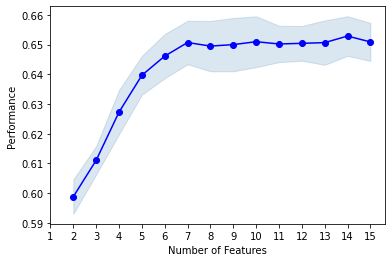

In [51]:
sfs1 = SFS(estimator=RF_sub, k_features=(1, 15),forward=True, floating=False, scoring='roc_auc',cv=5)

sfs1.fit(X_train_sub,y_train_sub)

print('best combination (ACC: %.3f): %s\n' % (sfs1.k_score_, sfs1.k_feature_names))

plot_sfs(sfs1.get_metric_dict(), kind='std_err');

In [62]:
k_features = list(sfs1.k_feature_names_)
RF_sub_feat = RandomForestClassifier(max_depth=10,max_features=2,n_estimators=500,random_state=0)

print("\nValidação Cruzada")
evaluateVal(RF_sub_feat,X_train_sub[k_features],y_train_sub)

#treino
RF_sub_feat.fit(X_train_sub[k_features],y_train_sub)

evaluate(RF_sub_feat,X_test[k_features],y_test)


Validação Cruzada
AUC = 0.6528805221833318
Revocação = 0.7495126705653021, Especificidade = 0.513839959738299, AUC = 0.6316763151518006


Comentário sobre a remoção de algumas features realmente fazerem diferença.

# Modelo Proposto

Dado os resultados acima escolhemos como modelo final a Random Forest **RF_sub**  que foi treinado com o subsample que iguala o número de clientes bons e maus pagadores. O modelo selecionado atingiu AUC = 0.639, com uma boa Revocação = 0.76 e uma Especificidade = 0.518. Os primeiros modelos,**RF e XG**, treinados com os todos os samples disponíveis atingiram um resultado ruim, RF e XG ambos tiveram grandes Especificidades isso é, estão prevendo quase todos os clientes como maus clientes já que a Revocação foi 0 para ambos. Os modelos treinados com oversampling **RF_over e XG_over** tem um desempenho melhor do que os primeiros modelos mas são piores que os modelos treinados com o subsampling.

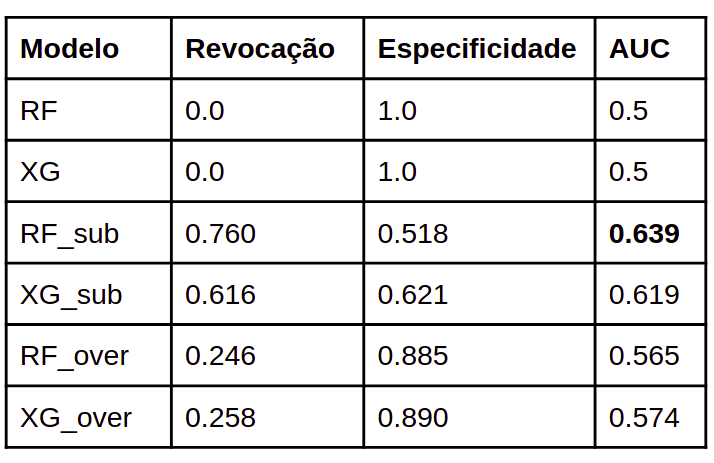

# Analisando importancia das Features para o modelo

In [78]:
perm = PermutationImportance(RF_sub, random_state=0).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = list(features[1:16]))

Weight,Feature
0.0458 ± 0.0061,debt3
0.0183 ± 0.0069,demo1
0.0111 ± 0.0057,demo3
0.0094 ± 0.0038,debt1
0.0080 ± 0.0038,income2
0.0077 ± 0.0024,demo4
0.0068 ± 0.0042,demo5
0.0045 ± 0.0045,job4
0.0044 ± 0.0033,demo6
0.0037 ± 0.0045,job3


In [79]:
explainer = shap.TreeExplainer(RF_sub)

In [80]:
row_to_show = 1

data_for_prediction = X_test.iloc[row_to_show]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

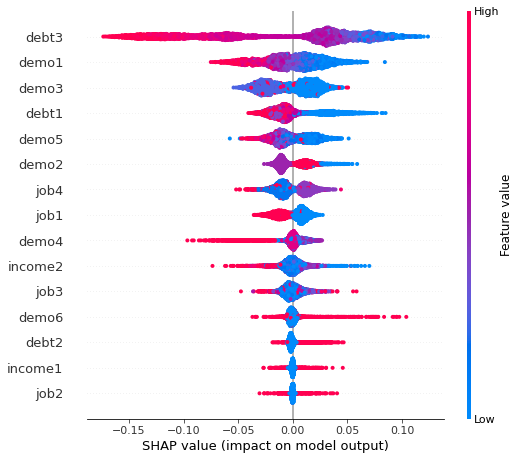

In [70]:
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test)